In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# Nike vs. Adidas shoes EDA

#### by: Moiezali Ismail

## Introduction
### 1. The Context
Adidas and Nike, two titans in the sportswear industry, have long been at the forefront of innovation, style, and marketing. While both brands enjoy global recognition and a strong customer base, there is an ongoing debate regarding their market positioning, customer preferences, and brand perception. Understanding the nuances of this rivalry is crucial for stakeholders in the sportswear market, as it sheds light on consumer behavior and emerging trends.

### 2. The Objective
The primary goal of this analysis is to conduct a comprehensive comparison between Adidas and Nike, focusing on aspects such as market share, product innovation, brand strategies, and customer loyalty. This project aims to unravel the factors that define the competitive edge for each brand and how they resonate with their respective consumer demographics. Insights from this analysis are intended to inform marketing strategies and product development in the sportswear sector.

### 3. The Key Questions
- What are the differences between the numerical variables(Price, Discount, Rating, and Sale price)between the two giants in the current market?
- Is there any correlation between rating and listing price or any other variables? If so, to what degree?

# Table of contents

#### Table of contents: 
- [Initial observations](#Initial-observations)
- [Data cleaning](#Data-cleaning)
- [Data cleaning summary](#Data-cleaning-summary)
- [Analysis](#Analysis)
- [Exporting to cloud](#Exporting-to-cloud) 
- [Insights + recommendations](#Insights-and-recommendations) 
- [Conclusion](#Conclusion)

In [35]:
import plotly.io as pio
pio.renderers.default = "svg"
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import pearsonr, uniform, norm, t, shapiro, mannwhitneyu, ranksums
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

In [36]:
data = pd.read_csv('/Users/moiezismail/projects/shoes/shoes_raw_data.csv')

## Initial observations

In [37]:
# 5 random rows to have a look at the data
data.sample(5)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating,Reviews,Last Visited
2427,Men's adidas Football Predator 19.3 Turf Boots,EF8210,6599,3959,40,Adidas SPORT PERFORMANCE,These football boots are designed to deliver r...,2.50,64,2020-04-13T15:07:52
237,Men's adidas Sport Inspired Grand Court Shoes,EE7884,6999,4199,40,Adidas CORE / NEO,A modern update to '70s style. These court-ins...,2.50,2,2020-04-13T15:06:27
1447,Women's adidas Running Alphabounce Instinct Shoes,D97319,8999,4499,50,Adidas SPORT PERFORMANCE,The athlete's running shoe. These shoes have a...,3.70,29,2020-04-13T15:07:11
952,MEN'S ADIDAS SPORT INSPIRED COURT 70S SHOES,B79771,5599,2799,50,Adidas CORE / NEO,Classic court style with a minimalist approach...,5.00,65,2020-04-13T15:06:52
2745,Nike Tiempo Legend 8 Elite FG,AT5293-004,0,20995,0,Nike,The Nike Tiempo Legend 8 Elite FG takes the le...,3.10,7,2020-04-13T15:28:23


#### Observations
- listing and sale price is without a decimal, so the interger value is in the tens of thousands
- Nike has products with listing price as 0(non-null missing value) but a sale price which would skew analysis and aggregation 
- Reviews are a count rather than text

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product Name   3268 non-null   object 
 1   Product ID     3268 non-null   object 
 2   Listing Price  3268 non-null   int64  
 3   Sale Price     3268 non-null   int64  
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Description    3265 non-null   object 
 7   Rating         3268 non-null   float64
 8   Reviews        3268 non-null   int64  
 9   Last Visited   3268 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 255.4+ KB


#### Observations
- the data is limited as we do not have a sales count variable which we can use to make a prediction
- 3268 entries with the Description column missing only 3 entries
- last visited column is useless for this analysis 

In [39]:
data.nunique()

Product Name     1531
Product ID       3179
Listing Price      78
Sale Price        227
Discount            6
Brand               5
Description      1762
Rating             32
Reviews           102
Last Visited      318
dtype: int64

#### Observations
- not every product ID is unique

#### Count non-null missing values ( 0s) 

In [40]:
zero_ratings_count = (data['Rating'] == 0).sum()
zero_listing_prices_count = (data['Listing Price'] == 0).sum()

print(f"Rating: {zero_ratings_count}")
print(f"Listing price: {zero_listing_prices_count}")


Rating: 302
Listing price: 426


#### observations
- Ratings and listing price have quite a large number of 0s where 0s don't make sense as a shoe cannot have a 0 rating, nor does a 0 for listing price mean it's free(no payment required etc.) i.e. 0s will create incorrect and inaccurate aggregations 

## Data cleaning 

#### cleaning: drop duplicates and irrelevant columns

In [41]:
data.drop_duplicates(subset=['Product ID', 'Product Name'], inplace=True)

data.drop(columns=['Last Visited', 'Reviews'], inplace=True)

####  cleaning: correcting the numerical format for price 

In [42]:
data[['Listing Price','Sale Price']] = data[['Listing Price','Sale Price']] / 100.0

In [43]:
data.sample(2)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating
1514,Men's adidas Originals Nizza Shoes,EE5602,59.99,35.99,40,Adidas ORIGINALS,adidas Originals brings back a classic with th...,2.40
1446,Men's adidas Originals X_PLR S Shoes,EF5507,75.99,75.99,0,Adidas ORIGINALS,See the city by foot in the X_PLR S. These adi...,3.30


#### cleaning: renaming some columns

In [44]:
data.rename(columns={'Discount': 'Discount %', 'Product ID':'Product_ID'}, inplace=True)

#### count the number of Nike products vs. Adidas


In [45]:
nike_prods = sum(data["Brand"].str.contains("Nike", case=True))
adidas_prods = 3268 - nike_prods

f"Nike products:{nike_prods} and Adidas products:{adidas_prods} so abbout 75% more products adidas products than Nike" 


'Nike products:554 and Adidas products:2714 so abbout 75% more products adidas products than Nike'

#### cleaning: creating binary category for products into either Nike or Adidas

In [46]:
data['Company'] = data['Brand'].apply(
    lambda x: 'Nike' if 'Nike' in x else 'Adidas' if 'Adidas' in x else 'Other')

data.drop('Brand', axis=1, inplace=True)

In [47]:
# Check to see if there are only 2 different values in the Company column as intended 
data.Company.nunique()

2

#### Statistical summary to see the spread of numerical data for both companies

In [48]:
data[data['Company'] == 'Adidas'].describe()

,Listing Price,Sale Price,Discount %,Rating
count,2625.00,2625.00,2625.00,2625.00
mean,76.01,51.35,33.46,3.37
std,40.71,35.90,20.43,1.16
min,8.99,4.49,0.00,0.00
25%,49.99,27.99,0.00,2.70
50%,65.99,39.99,40.00,3.50
75%,89.99,64.99,50.00,4.30
max,299.99,299.99,60.00,5.00


In [49]:
data[data['Company'] == 'Nike'].describe()

,Listing Price,Sale Price,Discount %,Rating
count,554.00,554.00,554.00,554.00
mean,40.98,102.48,0.00,2.80
std,60.72,42.67,0.00,2.12
min,0.00,15.95,0.00,0.00
25%,0.00,71.97,0.00,0.00
50%,0.00,99.95,0.00,3.90
75%,89.95,129.45,0.00,4.60
max,199.95,365.00,0.00,5.00


In [50]:
(data[data['Company'] == 'Nike']['Listing Price']== 0).sum()

362

#### Observation
- Nike data has missing non-null values for listing price; we'll have to impute them as sale price if it's 0. 

#### cleaning: impute listing price from sales price 
- Essentially, the following code swaps the values of 'Sale Price' into 'Listing Price' where 'Listing Price' is zero and sets 'Sale Price' to zero for those cases. 

In [51]:
# Create a boolean mask for rows where 'Listing Price' is 0
zero_rows = (data['Listing Price'] == 0)

# Use boolean indexing to update the values in 'Listing Price' and 'Sale Price' columns
data.loc[zero_rows, 'Listing Price'] = data.loc[zero_rows, 'Sale Price']
data.loc[zero_rows, 'Sale Price'] = 0

In [52]:
# 0 as a Sale price does not make sense as shoes cannot be discounted to
# the point of being free 
data['Sale Price'].replace(0, np.nan, inplace=True)

In [53]:
data.sample(3)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
1164,Men's adidas Football Predator 19+ Firm Ground...,F35613,229.99,137.99,40,Predator isn't just a cleat. It's a statement ...,4.60,Adidas
2513,Men's adidas Basketball Dame 5 Shoes,EF0500,129.99,77.99,40,"Made to play fresh out of the box, these baske...",3.60,Adidas
1648,Men's adidas Swim Stabile Slippers,CM6080,12.99,12.99,0,The simple and stylish adidas Stabile slippers...,4.20,Adidas


#### cleaning: impute the % discount if Nike products have a different listing price than sale price excluding zero

In [54]:
data['Discount %'] = data.apply(lambda row: 
                            (row['Listing Price'] - row['Sale Price']) / row['Listing Price'] 
                            * 100 if row['Sale Price'] != 0 else 0, axis=1)

#Round the % to a whole number for neater analysis
data[['Listing Price','Sale Price','Discount %']] = np.round(data[[
    'Listing Price','Sale Price','Discount %']])

# Impute the Sale Price with Listing Price where Discount % is 0
data.loc[data['Discount %'] == 0, 'Sale Price'] = data['Listing Price']

In [55]:
data.sample(3)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
1704,Men's Sports Inspired Daily 2.0 Shoes,DB0271,50.00,25.00,50.00,The definitive daily sneaker. These classic sh...,4.90,Adidas
1770,MEN'S ADIDAS RUNNING NEBULAR 2.0 SHOES,CJ8104,50.00,25.00,50.00,Make your running or jogging sessions even mor...,2.70,Adidas
2937,Nike Zoom Gravity,BQ3203-007,80.00,64.00,20.00,"Designed to make fast go faster, the Nike Zoom...",3.70,Nike


#### cleaning: imputing the mean into NULL 
- 1) turn non-null missing values(i.e. 0) into null
- 2) calculate mean from leftover values 
- 3) impute that aggregated value into the NaN cells(formerly 0)

In [56]:
data['Rating'] = data['Rating'].replace(0, np.nan).fillna(data['Rating'].mean())

In [57]:
data[['Listing Price', 
      'Sale Price', 
      'Discount %']] = data[['Listing Price', 
                             'Sale Price',
                             'Discount %']].fillna(0).astype('int64')

In [58]:
data.sample(5)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
1196,Men's adidas Running EnergyFalcon Shoes,EE9852,76,76,0,Dig deep. These running shoes have a supportiv...,4.30,Adidas
714,Men's adidas Running Fluidcloud Neutral Shoes,BB7614,60,30,50,Feel as cool as you look with this adidas Flui...,4.20,Adidas
790,Men's adidas Sport Inspired Syan Shoes,CL7273,50,30,40,These men's running-inspired shoes keep you co...,3.80,Adidas
1402,Unisex adidas Originals Skateboarding 3MC Shoes,EE6074,60,36,40,"Designed for skate but with an easy, everyday ...",2.00,Adidas
848,WOMEN'S ADIDAS ORIGINALS FOREST GROVE SHOES,AQ1220,70,35,50,Inspired by a game-changing running shoe from ...,3.10,Adidas


### Feature engineering 
- Value  = rating / listing 
- the higher the value, the better the deal based on rating vs. price

In [59]:
data['value'] = round(data['Listing Price'] / data['Rating'])

In [60]:
data = data.reindex(columns=['Product_ID','Product Name', 'Company',
                             'Listing Price','Sale Price','Rating',
                             'Discount %','value','Description'])

In [61]:
data.isnull().sum()

Product_ID       0
Product Name     0
Company          0
Listing Price    0
Sale Price       0
Rating           0
Discount %       0
value            0
Description      3
dtype: int64

In [62]:
data.sample(3)

,Product_ID,Product Name,Company,Listing Price,Sale Price,Rating,Discount %,value,Description
2892,315122-001,Nike Air Force 1 '07,Nike,73,0,4.50,0,16.00,"Hoops in the park, Sunday BBQs and sunshine. T..."
1881,CM5922,Men's adidas Outdoor Argo Trek 19 Shoes,Adidas,40,28,3.50,30,11.00,Ready for outdoor adventures? These men's trek...
949,EE5641,Men's adidas Originals Sobakov P94 Shoes,Adidas,76,46,4.40,40,17.00,The Sobakov honors the spirit of modern soccer...


In [63]:
shoes = data.copy()

### Limitations of the dataset : 
Before we get started on the analysis, I want to go over a few things: 

1. The dataset lacks a continuous target variable such as sales, or profits/losses, and geographic data(Store/countries where those sales occured) which limited inferential analysis for performance between Nike and Adidas. 

2. There were far more Adidas products than Nike which significantly affected affected count plot/analysis, so we had to compare everything in averages 

3. Since none of the variables were normally distributed, it was difficult to perform tests like t-tests, ANOVA etc. between the means of Nike vs. Adidas.

### Export data to csv

shoes.to_csv('shoes.csv', index=False)

## Data exported out to Google Cloud Platform(GCP) for use in BigQuery

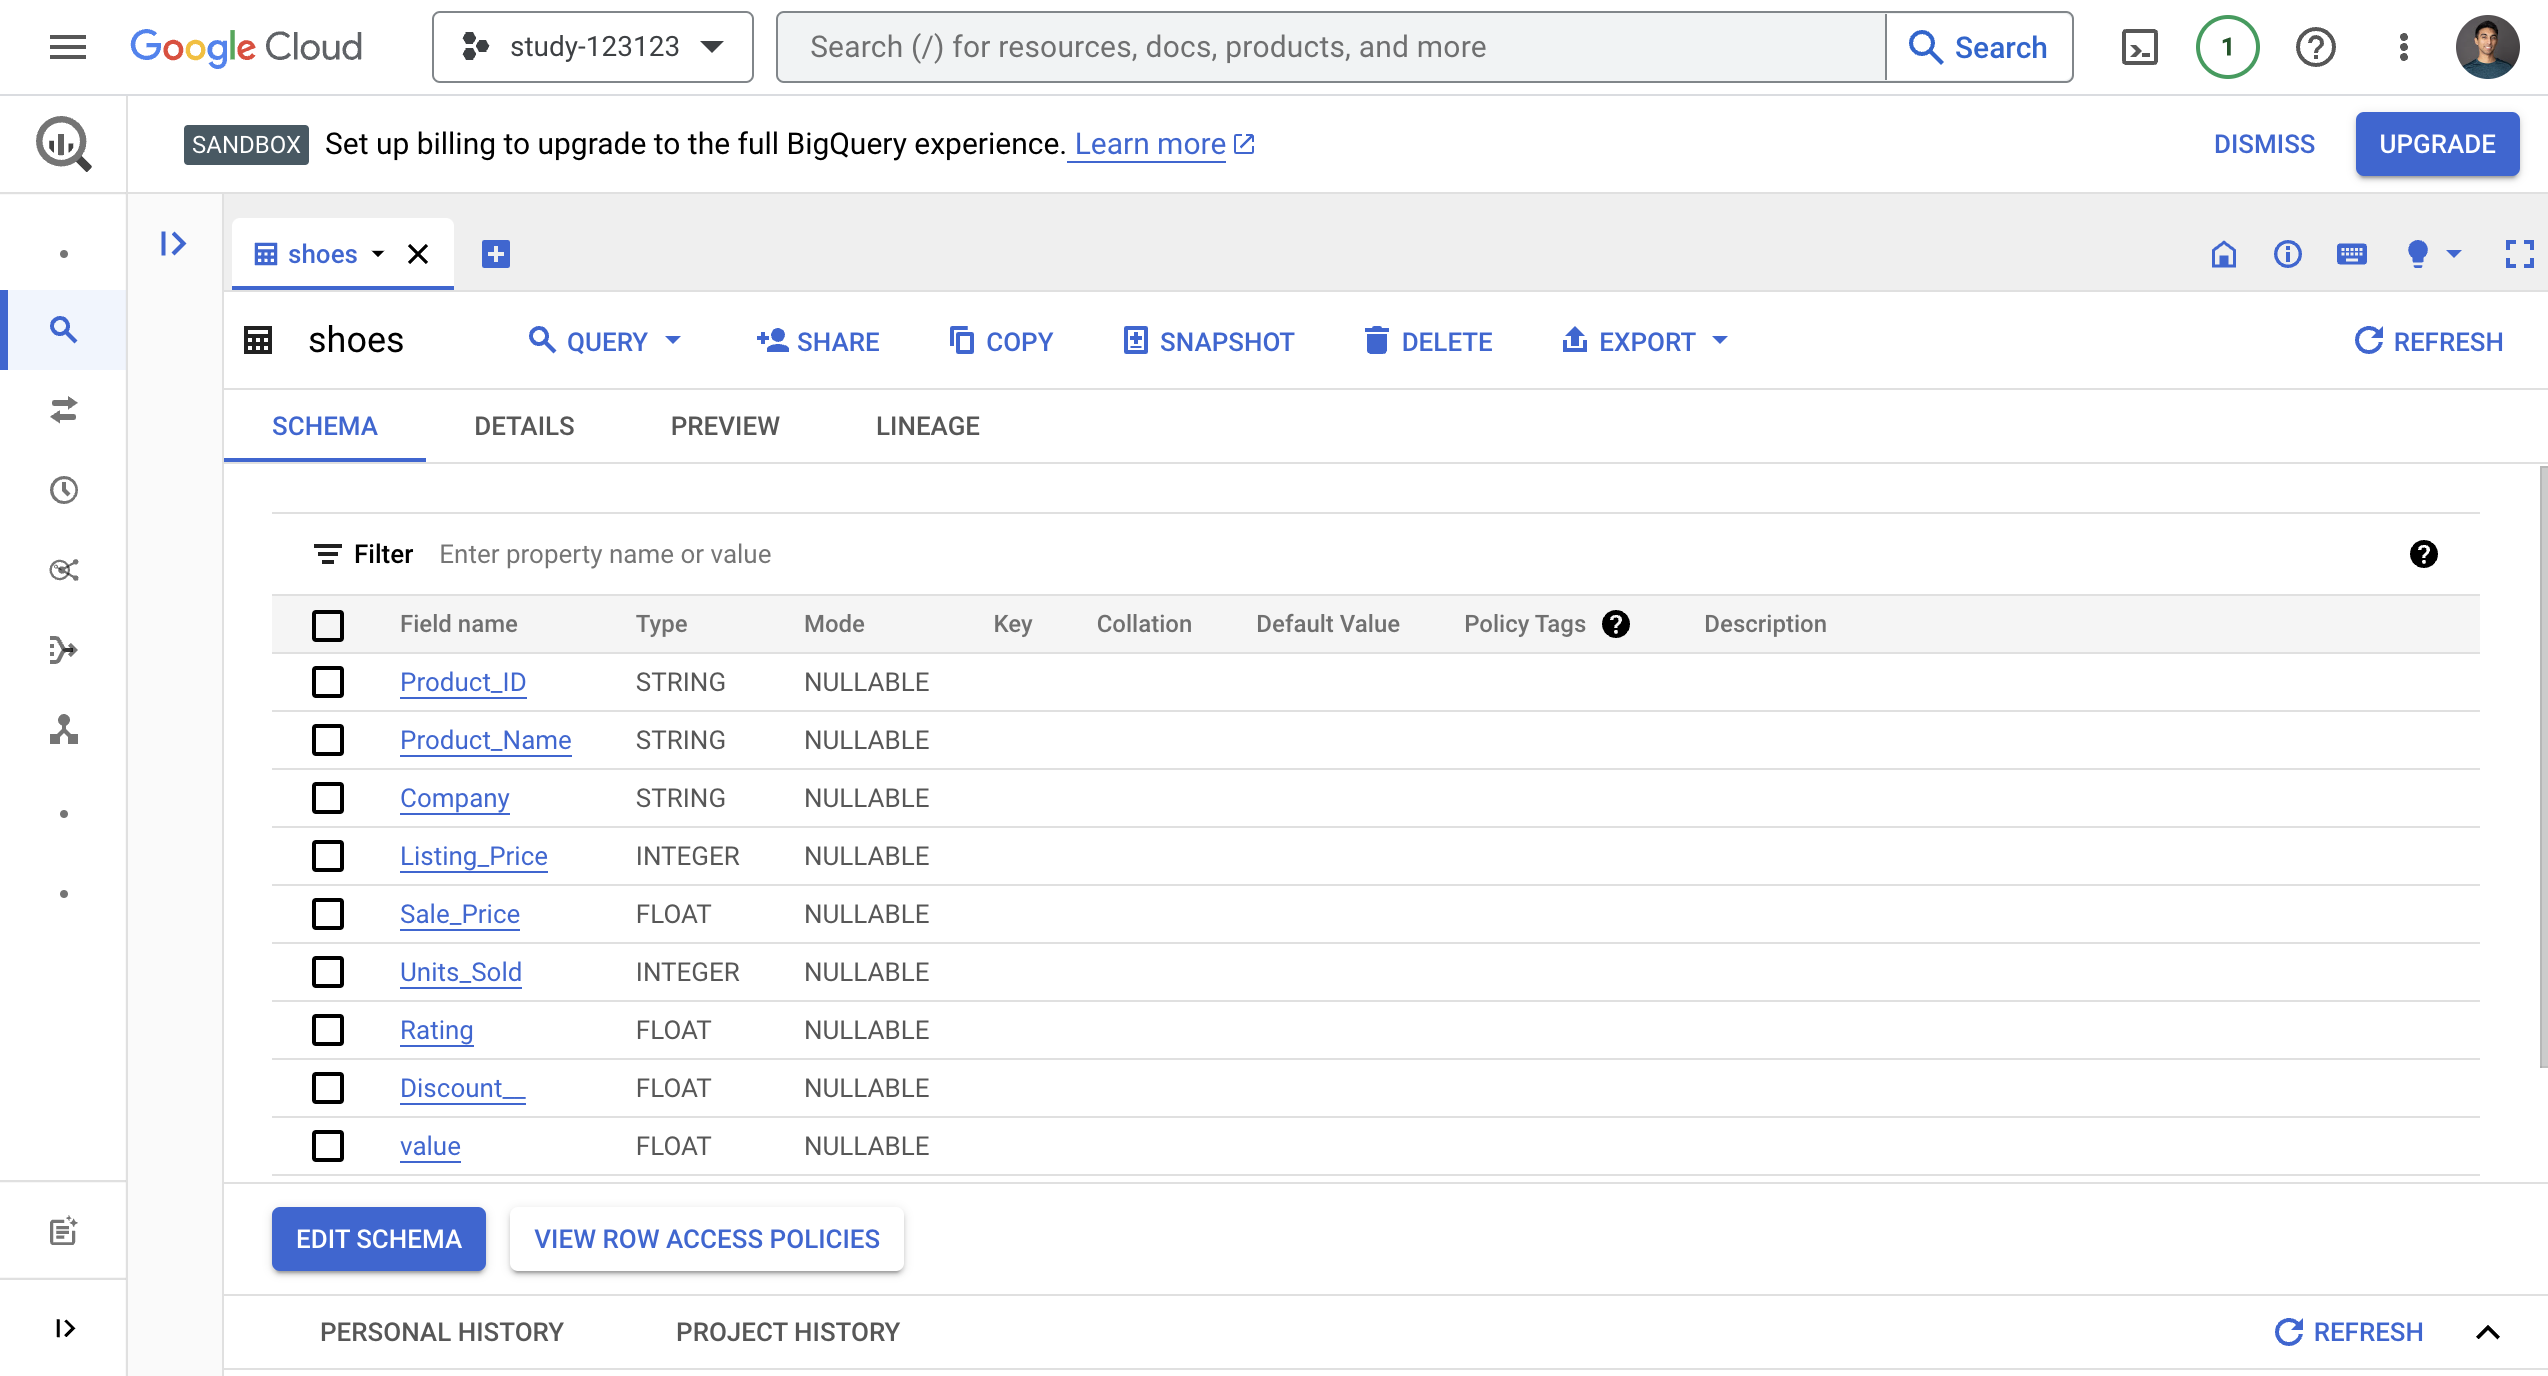

## Analysis

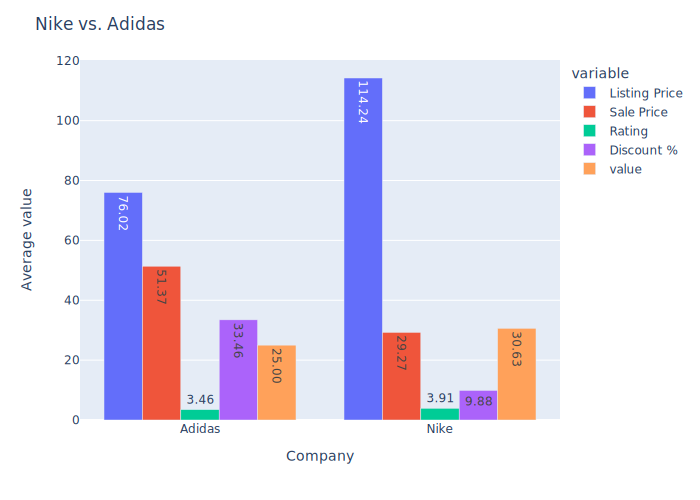

In [64]:
#　A quick glance at the average of the numerical columns for both Nike and Adidas 
company_avg = shoes.groupby('Company').mean()

fig_comp = px.bar(company_avg, barmode='group')

fig_comp.update_traces(texttemplate='%{y:.2f}', textposition='auto') # round the y-values to 2 decimal places

fig_comp.update_layout(title="Nike vs. Adidas", 
                  xaxis_title="Company", yaxis_title='Average value')

#### Observations: Nike vs. Adidas
1. Nike shoes, on average, cost almost $40 more and have 0.66 points higher rating
2. Nike's average sale price is about 30 USD higher
3. Adidas gives higher discounts on average than Nike
4. Adidas however has a higher value ratio than Nike

#### Nike and Adidas subsets

In [65]:
# Creating subsets of the data filtered by company
nike = shoes[shoes['Company'] == 'Nike']
adidas = shoes[shoes['Company'] == 'Adidas']

In [66]:
np.round(nike.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Listing Price,554.00,114.24,43.23,16.00,80.00,110.00,150.00,365.00
Sale Price,554.00,29.27,43.85,0.00,0.00,0.00,64.00,160.00
Rating,554.00,3.91,0.80,1.00,3.27,3.90,4.60,5.00
Discount %,554.00,9.88,14.33,0.00,0.00,0.00,20.00,40.00
value,554.00,30.63,14.95,4.00,21.00,28.00,37.00,170.00


In [67]:
np.round(adidas.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Listing Price,2625.00,76.02,40.71,9.00,50.00,66.00,90.00,300.00
Sale Price,2625.00,51.37,35.90,4.00,28.00,40.00,65.00,300.00
Rating,2625.00,3.46,1.01,1.00,2.80,3.50,4.30,5.00
Discount %,2625.00,33.46,20.43,0.00,0.00,40.00,50.00,60.00
value,2625.00,25.00,18.58,2.00,13.00,20.00,31.00,230.00


#### Observations
- **Price**: Nike's highest priced shoe at USD 365 indicates a higher-end market positioning compared to Adidas, whose highest is USD 300. Nike shows a broader price range with a higher interquartile range, suggesting a diverse product offering.
- **Ratings**: On average, Nike has higher ratings based off the average and standard deviation.
- **Value**: Nike has a higher average value score with less variability, suggesting more consistent value, whereas Adidas has the highest value shoe at USD 230.
- **Discount**: Adidas offers significantly higher average discounts with more variability, suggesting a strategy focused on sales promotions.
- **Sale Price**: Nike's products have a higher average sale price with a broader range, reinforcing its premium market positioning.

<AxesSubplot: >

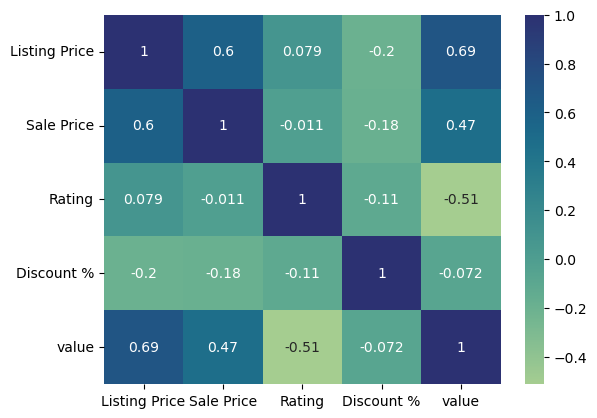

In [68]:
# Correlation matrix for the numerical variables for both Nike and Adidas combined

sns.heatmap(data=shoes.corr().T, annot=True, cmap='crest')

#### Observations: 
1. There is a strong correlation between Listing Price and Sale Price 
2. There is a moderate correlation between Sale price and Rating. 
3. And as expected, there is a correlation(although weak) between rating and value ratio

### univariate analysis
We'll have a look at the 3 following variables' distribution: 
1. Listing price
2. Discount %
3. Rating

#### 1. Is there a difference in the average Listing price between Nike and Adidas shoes?

**Observations** 
1. Both distributions seem to be quite right-skewed indicating outliers in the upper-end for prices
2. Adidas's mean around 50 dollars whereas Nike has a higher distribution around 80
2. We'll have to divide the listing price into 3 categories for better analysis and visualization later on for bivariate analysis

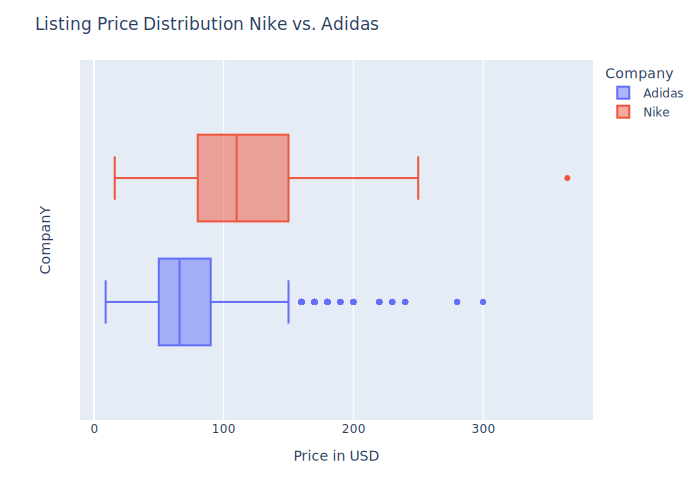

In [69]:
# Another perspective  
fig = px.box(shoes, x="Listing Price", color='Company')

fig.update_layout(title="Listing Price Distribution Nike vs. Adidas", 
                  xaxis_title="Price in USD",
                  yaxis_title="CompanY")
fig.show()

#### Observations
- right-skew for the listing price for both Nike and Adidas so it's not normally distributed
- Adidas prices has far more outliers

#### Hypothesis test: skewness of listing price 
- Shapiro - Wilk's test for normality test checks for normality of a numerical varible

State the hypothesis:
* $H_0:$ There is no skewness between the two company's average listing prices, it's normally distributed
* $H_1:$ There is skewness between the two company's average listing prices, it's not normally distributed

alpha = 0.05

In [80]:
# Create subset based on filter 
adidas_price = shoes[shoes['Company'] == 'Adidas']['Listing Price']
adidas_price.describe()

count   2625.00
mean      76.02
std       40.71
min        9.00
25%       50.00
50%       66.00
75%       90.00
max      300.00
Name: Listing Price, dtype: float64

#### Observation
- the average price of Adidas is at USD 76 with half of the total shoes between USD 50 and 90 
- the standard deviation is at about USD 40 and the highest priced shoe at USD 300

In [81]:
nike_price = shoes[shoes['Company'] == 'Nike']['Listing Price']
nike_price.describe()

count   554.00
mean    114.24
std      43.23
min      16.00
25%      80.00
50%     110.00
75%     150.00
max     365.00
Name: Listing Price, dtype: float64

#### Observation
- the average price of Nike shoes is much higher at USD 114 with half of the total shoes between USD 80 and 150 indicating Nike shoes enjoy a much larger price tag 
- the standard deviation is also smaller than Adidas's at about USD 43 meaning higher values throughout the dataset
-the highest priced shoe is 65 dollars higher than Adidas's max priced shoe

In [71]:
alpha = 0.05
adidas_shapiro_price = stats.shapiro(adidas_price)[1]
nike_shapiro_price = stats.shapiro(nike_price)[1]

def normal_test(alpha, p_val, brand):
    if p_val < alpha:
        return f"{brand} not normally distributed)"
    else:
        return f"{brand} is normally distributed)"

print(normal_test(alpha=alpha, p_val=adidas_shapiro_price, brand="Adidas"))
print(normal_test(alpha=alpha, p_val=nike_shapiro_price, brand="Nike"))


Adidas not normally distributed)
Nike not normally distributed)


#### Observation
- For both Nike and Adidas, shoes prices are not normally distributed, centering between 
- USD 65 and 150 
- data isn't normally distributed, we'll have to perform the Mann-Whitney U test to compare the central tendency of the listing prices between the two companies

#### Is there a significant difference between Nike and Adidas's listing prices? 

State the hypothesis:
* $H_0:$ There is no difference between the two company's average listing price
* $H_1:$ there is a difference between the two company's average listing price

alpha = 0.05

#### Bootstrapping + hypothesis testing: 
- Since the listing price data is not normally distributed, we have to do bootstrapping to compare the means with n-# of iterations

In [72]:
n_iterations = 1000
size = len(shoes)

# Separate the data into two groups: Nike and Adidas
nike_prices = shoes[shoes['Company'] == 'Nike']['Listing Price']
adidas_prices = shoes[shoes['Company'] == 'Adidas']['Listing Price']

# Initialize arrays to store bootstrap sample means
nike_means = np.zeros(n_iterations)
adidas_means = np.zeros(n_iterations)

# Generate bootstrap samples and compute means
for i in range(n_iterations):
    nike_sample = np.random.choice(nike_prices, size=size, replace=True)
    adidas_sample = np.random.choice(adidas_prices, size=size, replace=True)
    nike_means[i] = nike_sample.mean()
    adidas_means[i] = adidas_sample.mean()
# Observed difference in means
observed_diff = nike_prices.mean() - adidas_prices.mean()

# Calculate the difference in bootstrap sample means
diff_means = nike_means - adidas_means

# Calculate the p-value
# The p-value is the probability of getting the observed difference (or more extreme) 
# in the bootstrap samples if the null hypothesis (no difference in means) is true
p_value = np.sum(diff_means >= observed_diff) / n_iterations

# Print the results
print(f"Observed difference in means: ${round(observed_diff)}")

if p_value > 0.05:
    print('There is no significant difference in the average listing price')
else:
    print('There is a significant difference in the average price')

Observed difference in means: $38
There is no significant difference in the average listing price


#### Observation
- Most Nike shoes on average are USD $38 more than Adidas shoes
- Considering the spread, there isn't a significant difference in the average price between the companies 

#### Distribution of discount %

In [73]:
shoes[shoes['Company']=='Nike']['Discount %'].describe()

count   554.00
mean      9.88
std      14.33
min       0.00
25%       0.00
50%       0.00
75%      20.00
max      40.00
Name: Discount %, dtype: float64

In [74]:
shoes[shoes['Company']=='Adidas']['Discount %'].describe()

count   2625.00
mean      33.46
std       20.43
min        0.00
25%        0.00
50%       40.00
75%       50.00
max       60.00
Name: Discount %, dtype: float64

#### Observation
-Adidas is far more generous with discounts compared to Nike since 50% of Adidas shoes are offered at substantial discounts of 40% or more
- Over half of Nike's shoes are not discounted at all, as indicated by a median discount of 0%

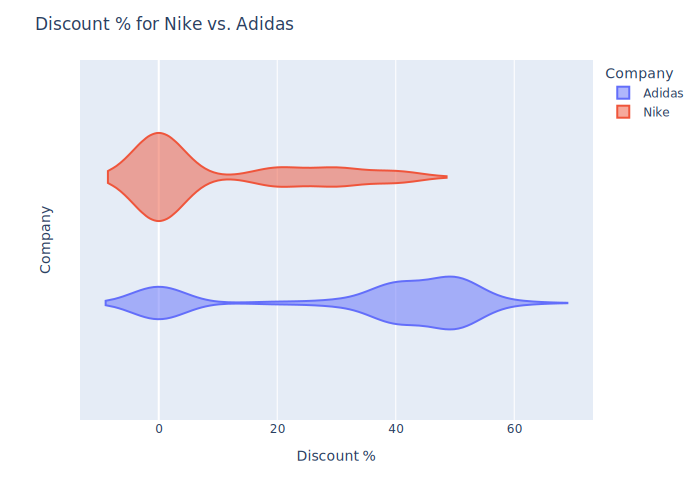

In [82]:
# Let's visualize to see how that looks with a violin plot
fig = px.violin(shoes, x="Discount %", color='Company')

fig.update_layout(title="Discount % for Nike vs. Adidas", 
                  xaxis_title="Discount %",
                  yaxis_title="Company")
fig.show()

#### Rating distribution

In [77]:
shoes[shoes['Company']=='Nike']['Rating'].describe()

count   554.00
mean      3.91
std       0.80
min       1.00
25%       3.27
50%       3.90
75%       4.60
max       5.00
Name: Rating, dtype: float64

In [78]:
shoes[shoes['Company']=='Adidas']['Rating'].describe()

count   2625.00
mean       3.46
std        1.01
min        1.00
25%        2.80
50%        3.50
75%        4.30
max        5.00
Name: Rating, dtype: float64

#### Observation
- Opposite to the discount %, Nike has a right skewed distribution indicating many values(ratings) towards the upper end
- Adidas has a lower average and a higher standard deviation meaning there are more shoes lower rated than Nike but both shoes have a max rating at 5 

#### Value

In [87]:
shoes[shoes['Company']=='Nike']['value'].describe()

count   554.00
mean     30.63
std      14.95
min       4.00
25%      21.00
50%      28.00
75%      37.00
max     170.00
Name: value, dtype: float64

In [88]:
shoes[shoes['Company']=='Adidas']['value'].describe()

count   2625.00
mean      25.00
std       18.58
min        2.00
25%       13.00
50%       20.00
75%       31.00
max      230.00
Name: value, dtype: float64

#### Observation
- Nike shoes are on average giving a higher value than Adidas with less of a standard deviation
- Adidas has the highest value shoe at 230 meaning Adidas gives a better value for the listing price 

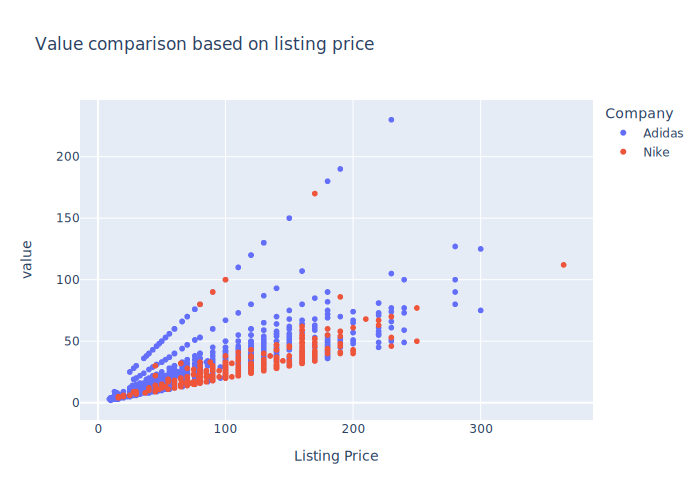

In [90]:
px.scatter(shoes, x='Listing Price', y='value', color='Company',
          title='Value comparison based on listing price')

### Bivariate analysis

#### Question: Is there a correlation between listing price and rating for Nike and Adidas? 

State the hypothesis:
* $H_0:$ There is no correlation between Listing price and Rating
* $H_1:$ There is a correlation between Listing price and Rating

alpha = 0.05

In [110]:
alpha = 0.05
nike_test_stat, nike_p_val = stats.pearsonr(nike['Rating'], nike['Listing Price'])
if nike_p_val > alpha:
    print(f"Failed to reject the null {round(nike_p_val,3)}, there is no correlation")
else:
    print(f"Evidence to reject the null at {round(nike_p_val,3)}, there is a correlation")
print(f"Nike correlation coefficient: {round(nike_test_stat,2)}")

Failed to reject the null 0.063, there is no correlation
Nike correlation coefficient: 0.08


In [111]:
alpha = 0.05
adidas_test_stat, adidas_p_val = stats.pearsonr(adidas['Rating'], adidas['Listing Price'])
if adidas_p_val > alpha:
    print(f"Failed to reject the null at {round(adidas_p_val,3)}, there is no correlation")
else:
    print(f"Evidence to reject the null at {round(adidas_p_val,3)}, there is a correlation")
print(f"Adidas correlation coefficient: {round(adidas_test_stat,2)}")

Failed to reject the null at 0.505, there is no correlation
Adidas correlation coefficient: 0.01


**Conclusion**
1. Based on a weak correlation coefficient of both Nike and Adidas, and higher p-value than alpha, we can say that there is no corellation between Rating and Listing price

#### Question: What portion of Nike and Adidas shoes are rated at least a 4.0? 

In [245]:
top_shoes = shoes[shoes['Rating'] >= 4]
print((top_shoes.groupby('Company')['Rating'].count()
                        / shoes.groupby('Company')['Rating'].count() * 100).round())


Company
Adidas   36.00
Nike     49.00
Name: Rating, dtype: float64


#### Observation
- Nike has a much larger portion of their shoes rated 4.0 or higher(almost 1/2) compared
-to Adidas's just over 1/3

## Regression analysis: Listing price vs. rating

In [110]:
# isolate the variables for regression
X1 = shoes['Listing Price']
y1= shoes['Rating']

X1 = sm.add_constant(X1)

reg1 = sm.OLS(y1, X1).fit()

shoes['best_fit1'] = reg1.predict(X1)

# Print out the R^2 value
print(f"R^2: {reg1.rsquared}")

R^2: 0.007975130776714634


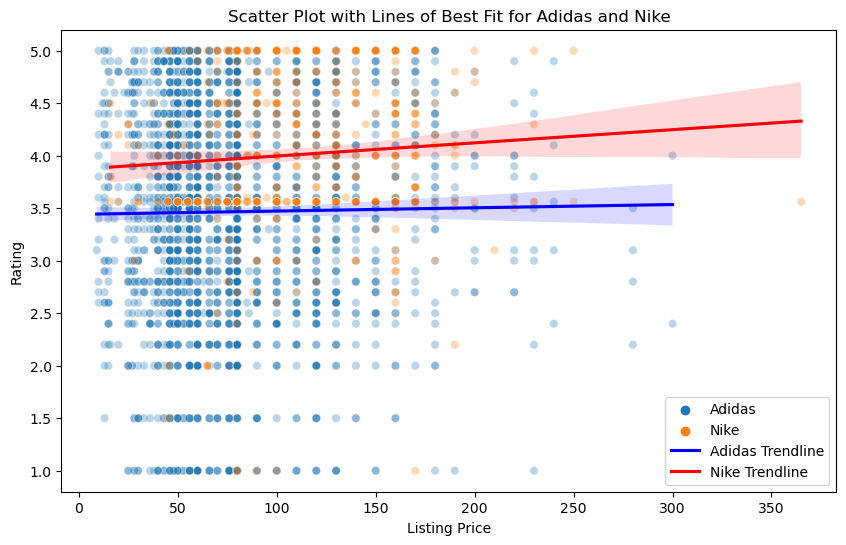

In [111]:
# Filter the DataFrame for Adidas and Nike
shoes_adidas = shoes[shoes['Company'] == 'Adidas']
shoes_nike = shoes[shoes['Company'] == 'Nike']

# Scatter plot with Seaborn including all data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=shoes, x='Listing Price', y='Rating', hue='Company', alpha=0.3)

# Regression line for Adidas
sns.regplot(data=shoes_adidas, x='Listing Price', y='Rating', scatter=False, 
            color='blue', label='Adidas Trendline')

# Regression line for Nike
sns.regplot(data=shoes_nike, x='Listing Price', y='Rating', scatter=False,
            color='red', label='Nike Trendline')

# Add title and labels as needed
plt.title('Scatter Plot with Lines of Best Fit for Adidas and Nike')
plt.xlabel('Listing Price')
plt.ylabel('Rating')

# Show the plot
plt.legend()
plt.show()

#### Observations from Regression Analysis:
- the R² value of 0.008 suggests that listing price only explains about 0.8% of the variance in shoe ratings, indicating other factors like brand image might be more influential
- Adidas's trendlind is higher than Nike's, indicating a better average rating at similar price points
- both companies have most products priced between \$50 and \$100, with ratings generally between 3.0 and 4.5.
- Nike's confidence interval is wider than Adidas', showing more variation in ratings at higher prices

## Insights and Recommendations
- The relationship between shoe quality/rating and price is influenced by the strong brand images of Nike and Adidas. Despite actual product quality, their reputations may lead to higher prices and favorable ratings.
- Post-cleaning data shows Nike's shoes are more expensive but also higher rated than Adidas. This aligns with Nike's significant market share in Athleisure wear.
- Adidas employs a strategy of offering larger discounts (up to 60%), which might drive sales. Conversely, Nike's discount strategy is less clear. Adidas might benefit from enhancing their brand to compete directly with Nike, potentially allowing for higher pricing based on perceived value.
- Both brands could adjust their discount strategies, offering larger discounts on expensive items and smaller discounts on lower-priced items, balancing sales attraction with brand image maintenance.

## Conclusion

Nike generally offers more expensive and higher-rated shoes, maintaining their market dominance, while Adidas provides more generous discounts, offering better value-for-price options. However, raises a question: Does Nike's market leadership primarily derive from its global brand presence, shaped by marketing and high-profile athlete endorsements? I believe these approaches contribute to a perceived image of superior quality and value, distinguishing Nike from competitors like Adidas, Reebok, Under Armour etc. 